In [2]:
# Append web folder to system path
import sys
sys.path.append('../web')

In [3]:
from db_config import Base
from Database import Station, Availability, Weather
from sqlalchemy import create_engine, func, Column, String, Integer, Double, Boolean
from sqlalchemy.orm import sessionmaker
import json
import sys

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [10]:
# Get the db_info
with open('../dbinfo.json') as f:
    db_info = json.load(f)


USER = db_info['dbConnection']['USER']
PASSWORD = db_info['dbConnection']['PASSWORD']
URI = db_info['dbConnection']['URI']
PORT = db_info['dbConnection']['PORT']
DB = db_info['dbConnection']['DB']

# Create a new session
engine = create_engine(
    'mysql+pymysql://{}:{}@localhost:{}/{}'.format(USER, PASSWORD, PORT, DB), echo=True)
Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()
print("connected")


2024-03-29 16:25:32,016 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-03-29 16:25:32,018 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-29 16:25:32,051 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-03-29 16:25:32,052 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-29 16:25:32,069 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-03-29 16:25:32,071 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-29 16:25:32,105 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-03-29 16:25:32,107 INFO sqlalchemy.engine.Engine DESCRIBE `db_on_your_bike`.`stations`
2024-03-29 16:25:32,108 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-29 16:25:32,127 INFO sqlalchemy.engine.Engine DESCRIBE `db_on_your_bike`.`availability`
2024-03-29 16:25:32,128 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-29 16:25:32,145 INFO sqlalchemy.engine.Engine DESCRIBE `db_on_your_bike`.`weather`
2024-03-29 16:25:32,146 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-29 16:25:3

In [11]:
weather = session.query(Weather).all()

for row in weather:
    print(row.time_updated, row.type, row.temperature, row.humidity)


2024-03-29 16:25:33,208 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-03-29 16:25:33,213 INFO sqlalchemy.engine.Engine SELECT weather.time_updated AS weather_time_updated, weather.type AS weather_type, weather.description AS weather_description, weather.temperature AS weather_temperature, weather.feels_like AS weather_feels_like, weather.min_temp AS weather_min_temp, weather.max_temp AS weather_max_temp, weather.humidity AS weather_humidity, weather.wind_speed AS weather_wind_speed, weather.visibility AS weather_visibility, weather.clouds AS weather_clouds, weather.sunrise AS weather_sunrise, weather.sunset AS weather_sunset 
FROM weather
2024-03-29 16:25:33,214 INFO sqlalchemy.engine.Engine [generated in 0.00113s] {}


2024-02-20 16:05:05 Clouds 11.91 81
2024-02-20 16:10:05 Clouds 11.96 80
2024-02-20 16:15:05 Clouds 11.83 81
2024-02-20 16:20:05 Clouds 11.96 80
2024-02-20 16:25:05 Clouds 11.83 81
2024-02-20 16:30:06 Clouds 11.67 79
2024-02-20 16:35:04 Clouds 11.67 79
2024-02-20 16:40:04 Clouds 11.29 81
2024-02-20 16:45:04 Clouds 11.29 81
2024-02-20 16:50:04 Clouds 11.08 81
2024-02-20 16:55:04 Clouds 11.1 79
2024-02-20 17:00:05 Clouds 11.1 79
2024-02-20 17:05:05 Clouds 11.08 77
2024-02-20 17:10:05 Clouds 11.05 77
2024-02-20 17:15:05 Clouds 11.08 78
2024-02-20 17:20:05 Clouds 10.59 78
2024-02-20 17:25:05 Clouds 10.55 78
2024-02-20 17:30:05 Clouds 10.59 78
2024-02-20 17:35:05 Clouds 10.55 78
2024-02-20 17:40:05 Clouds 10.27 80
2024-02-20 17:45:05 Clouds 10.28 79
2024-02-20 17:50:05 Clouds 10.28 79
2024-02-20 17:55:05 Clouds 10.02 79
2024-02-20 18:00:05 Clouds 10.01 79
2024-02-20 18:05:05 Clouds 10.02 79
2024-02-20 18:10:04 Clouds 9.97 80
2024-02-20 18:15:05 Clouds 9.97 80
2024-02-20 18:20:05 Clouds 9.97 

In [16]:
bike_availability = session.query(Availability).all()


2024-03-29 13:37:12,561 INFO sqlalchemy.engine.Engine SELECT availability.station_id AS availability_station_id, availability.time_updated AS availability_time_updated, availability.bike_stands AS availability_bike_stands, availability.available_bikes AS availability_available_bikes, availability.available_bike_stands AS availability_available_bike_stands, availability.status AS availability_status 
FROM availability
2024-03-29 13:37:12,565 INFO sqlalchemy.engine.Engine [generated in 0.00442s] {}


In [17]:
availability_df = pd.DataFrame([row.__dict__ for row in bike_availability])


In [19]:
availability_df.drop('_sa_instance_state', axis=1, inplace=True)
availability_df.to_csv('availability.csv')

In [7]:
availability_df = pd.read_csv('availability.csv')
availability_df['time_updated'] = pd.to_datetime(availability_df['time_updated'])
availability_df.head()

,Unnamed: 0,time_updated,available_bikes,status,bike_stands,available_bike_stands,station_id
0,0,2024-02-20 16:05:06,2,OPEN,31,29,1
1,1,2024-02-20 16:10:06,1,OPEN,31,30,1
2,2,2024-02-20 16:15:06,1,OPEN,31,30,1
3,3,2024-02-20 16:20:06,4,OPEN,31,26,1
4,4,2024-02-20 16:25:06,4,OPEN,31,26,1


In [27]:
availability_df.sort_values('time_updated', inplace=True)

In [12]:
weather_df = pd.DataFrame([row.__dict__ for row in weather])
weather_df.drop('_sa_instance_state', axis=1, inplace=True)
weather_df.sort_values('time_updated', inplace=True)
weather_df.head()

,type,temperature,min_temp,humidity,visibility,sunrise,feels_like,time_updated,description,max_temp,wind_speed,clouds,sunset
0,Clouds,11.91,11.53,81,10000,1708414464,11.27,2024-02-20 16:05:05,few clouds,12.36,9.77,20,1708451020
1,Clouds,11.96,11.53,80,10000,1708414464,11.30,2024-02-20 16:10:05,few clouds,12.36,9.77,20,1708451020
2,Clouds,11.83,11.05,81,10000,1708414464,11.18,2024-02-20 16:15:05,few clouds,12.36,9.77,20,1708451020
3,Clouds,11.96,11.53,80,10000,1708414464,11.30,2024-02-20 16:20:05,few clouds,12.36,9.77,20,1708451020
4,Clouds,11.83,11.05,81,10000,1708414464,11.18,2024-02-20 16:25:05,few clouds,12.36,9.77,20,1708451020


In [25]:
weather_df.to_csv('weather.csv')

In [62]:
df = pd.merge_asof(availability_df, weather_df, on='time_updated')

In [63]:
df = df[['station_id', 'time_updated', 'available_bikes', 'available_bike_stands', 'temperature', 'wind_speed', 'humidity']]
df.head()

,station_id,time_updated,available_bikes,available_bike_stands,temperature,wind_speed,humidity
0,1,2024-02-20 16:05:06,2,29,11.91,9.77,81
1,96,2024-02-20 16:05:06,14,16,11.91,9.77,81
2,13,2024-02-20 16:05:06,14,16,11.91,9.77,81
3,95,2024-02-20 16:05:06,3,37,11.91,9.77,81
4,94,2024-02-20 16:05:06,0,40,11.91,9.77,81


In [64]:
df.dtypes

station_id                        int64
time_updated             datetime64[ns]
available_bikes                   int64
available_bike_stands             int64
temperature                     float64
wind_speed                      float64
humidity                          int64
dtype: object

In [65]:
df.to_csv('weather_availability_joined.csv')

In [15]:
df = pd.read_csv('weather_availability_joined.csv')
# Convert station_id to int64
df['station_id'] = df['station_id'].astype('int64')

# Convert time_updated to datetime64
df['time_updated'] = pd.to_datetime(df['time_updated'])

# Convert available_bikes, available_bike_stands, and humidity to int64
df['available_bikes'] = df['available_bikes'].astype('int64')
df['available_bike_stands'] = df['available_bike_stands'].astype('int64')
df['humidity'] = df['humidity'].astype('int64')

# Convert temperature and wind_speed to float64
df['temperature'] = df['temperature'].astype('float64')
df['wind_speed'] = df['wind_speed'].astype('float64')


In [16]:
# One hot encode day of the week
df['weekday'] = df['time_updated'].dt.day_name()
df['hour'] = df['time_updated'].dt.hour
one_hot_encoded = pd.get_dummies(df['weekday'])
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop('time_updated', axis = 1, inplace=True)
df.drop('weekday', axis = 1, inplace=True)
df.drop('Unnamed: 0', axis = 1, inplace=True)


df.head()

,station_id,available_bikes,available_bike_stands,temperature,wind_speed,humidity,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,2,29,11.91,9.77,81,16,False,False,False,False,False,True,False
1,96,14,16,11.91,9.77,81,16,False,False,False,False,False,True,False
2,13,14,16,11.91,9.77,81,16,False,False,False,False,False,True,False
3,95,3,37,11.91,9.77,81,16,False,False,False,False,False,True,False
4,94,0,40,11.91,9.77,81,16,False,False,False,False,False,True,False


In [17]:
print(one_hot_encoded.columns)

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')


In [18]:
unique_station_ids = df['station_id'].unique()

for station_id in unique_station_ids:

    temp_df = df[( df['station_id'] == station_id)]
    temp_train_df = temp_df[['temperature', 'wind_speed', 'humidity', 'hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

    x_train, x_test, y_train, y_test = train_test_split(temp_train_df, temp_df['available_bike_stands'], test_size = 0.1, random_state=23)


    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly_features = poly.fit_transform(x_train)

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y_train)

    with open(f'station_{station_id}.pkl', 'wb') as file:
        # Serialize and save the model to the file
        pickle.dump(poly_reg_model, file)



In [19]:
y_pred_train = poly_reg_model.predict(poly_features)

poly_test_features = poly.fit_transform(x_test)
y_pred_train = poly_reg_model.predict(poly_features)

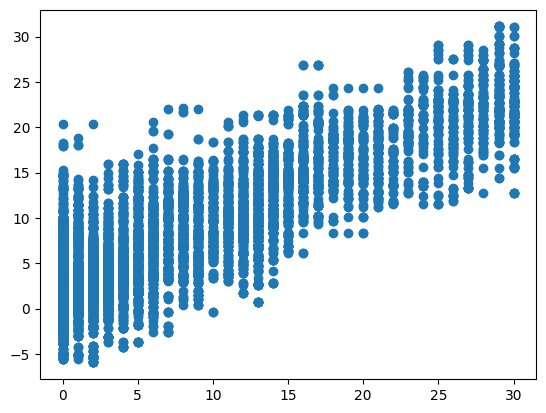

In [20]:
plt.scatter(y_train, y_pred_train)

In [21]:
with open('station_1.pkl', 'wb') as file:
    # Serialize and save the model to the file
    pickle.dump(poly_reg_model, file)

In [22]:
with open('station_1.pkl', 'rb') as file:
    # Load the model from the file
    poly_reg_model = pickle.load(file)


poly_reg_model.predict(poly_features)

array([ 2.83078764, 19.2916038 ,  1.18540414, ..., 10.83478916,
       16.65400034,  8.62991246])

In [23]:
def get_stations(station_id):
    poly = PolynomialFeatures(degree=3, include_bias=False)
    with open(f'station_{station_id}.pkl', 'rb') as file:
        # Load the model from the file
        poly_reg_model = pickle.load(file)

    
    predictions = poly_reg_model.predict(poly_features)
    # row = session.query(Availability).filter_by(station_id=station_id)
    return predictions

get_stations(1)

array([ 2.83078764, 19.2916038 ,  1.18540414, ..., 10.83478916,
       16.65400034,  8.62991246])